# Forecasting energy production of a power plant

We have a dataset that contains monthly values of energy production of a power plant (Megawatts). There are aproximately 33 years of observations

In this research my main goal is to create forecasting model for predicting further energy production. We need to do following tasks to reach the goal:
1. Split data in two parts: training and validation datasets
2. Analyze training dataset (check for trend, seasonality, distribution and others characteristics)
3. Create a naive model (persistance model) and evaluate its performance to create a baseline 
4. Create a forecasting model and evaluate it (I incline to ARIMA model)

In [1]:
# import all necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, log, exp

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Load data and make training and validation datasets

In [11]:
# load data
series = pd.read_csv('electric_production.csv', 
                     header=0, # first string interprets as column names
                     index_col=0, # first column interprets as indicies
                     parse_dates=True, # indicies interprets as dates
                     squeeze=True # instead of DataFrame object data 'squeezed' to Series object
                    )
# look at the header and tail
series

DATE
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048
Name: IPG2211A2N, Length: 397, dtype: float64

We have time series from January 1985 to January 2018. Let's examine data for missing values before spliting

In [13]:
series.count()

397

In [14]:
series.shape

(397,)

There are no missing values let's make split. Taking into consideration that time series have temporal structure we can apply standard train_test_split. We choose point in dataset and all previous data will be training set and latest data will be validation set.

In [15]:
# I want to leave for validation set 49 months of data (4 years and 1 month)
# It's about 12% of all data and leaves to training sets exactly 29 years of data (it will be useful for analysis)
split_point = len(series) - 49
dataset = series[:split_point]
validation = series[split_point:]
# save datasets
validation.to_csv('validation.csv', header=False)
dataset.to_csv('dataset.csv', header=False)

# Data Analysis

In [3]:
# load our training dataset
series = pd.read_csv('dataset.csv',
                     header=None,
                     index_col=0,
                     parse_dates=True,
                     squeeze=True
                    )

In [6]:
# let's see statistic characteristics of the dataset
series.describe()

count    348.000000
mean      86.795982
std       14.884605
min       55.315100
25%       74.805875
50%       87.539000
75%       97.956475
max      119.488000
Name: 1, dtype: float64

<AxesSubplot:ylabel='Density'>

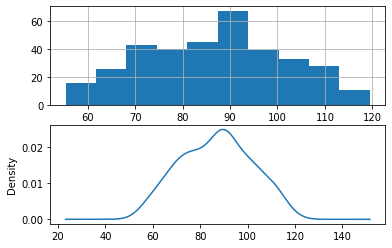

In [7]:
# look at the distribution of values
plt.figure()
plt.subplot(211)
series.hist() # draw histogram
plt.subplot(212)
series.plot(kind='kde') # draw density plot under histogram

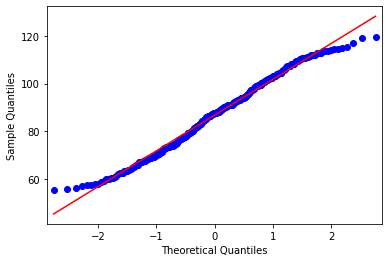

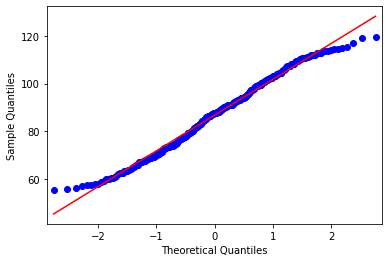

In [13]:
# draw Q-Q plot to make a conclusion
qqplot(series.values, line='r')

Ok now we can make a first conclusion: distribusion is not Gaussian. From density plot it looks more like triangle (sharp peak). From Q-Q plot we see that both tails of distribution highly differs from Gaussian.

Taking the above into consideration I assume to use power or log transformation of data (or both using boxcox transformation) before we start create a model, because non-normal disribution may cause decreasing of performance in machine learning algorithms.

<AxesSubplot:xlabel='0'>

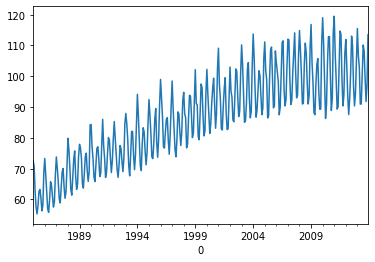

In [14]:
# Now let's draw simple line graph
series.plot()

From graph above clearly seen the trend (and maybe seasonality) and also increasing of variance during the time.

To confirm my judgments we group data by years and make boxplot and line graphs.

<AxesSubplot:>

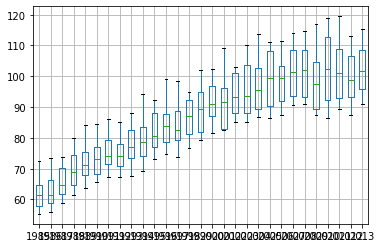

In [15]:
# create groups
groups = series.groupby(pd.Grouper(freq='A'))
# create an empty data frame
years = pd.DataFrame()
# start to fill dataframe
for name, group in groups:
    # in dataframe appends column with name of a year (1985, 1986 etc.)
    # values in columns are just values of energy for each month in concrete year 
    years[name.year] = group.values
# draw boxplot for each year
years.boxplot()

Width of bars increase during the time hence variance increase too, that confirms my decision to apply power or log transformation.

Median value also grow during the time but after 2005 there is a stagnation. To analyze the causes there are too litle data. But the trend is clearly seen which means that data is non-stationary and we must handle it before applying machine learning algorithms.

Now I want to draw line plots for every year on the same scope to check for seasonality.

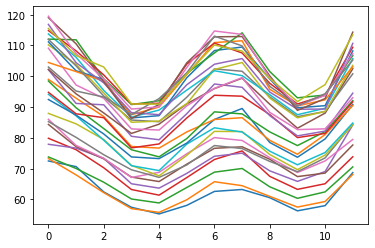

In [16]:
# for every year column draw it's own line plot
for year in years.columns:
    plt.plot(years[year])

From the graph above we may clearly see the seasonality of the data. In addition to trend it oblige us to take measures for making data stationary.

There are a few differenm methods to make data stationary. I try to use one that relies on data itself. We lost first year of data and will use following formula for new values:
new value = value[i] - value[i-12]

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    # create empty list 
    diff = list()
    # go through whole dataset
    # we may use any interval, but in our case we will use 12 (number of months) 
    for i in range(interval, len(dataset)):
        # subtract from current value the value of the same months of previous year
        value = dataset[i] - dataset[i - interval]
        # append that value to a new dataset
        diff.append(value)
    return diff

I want to check whether or not it helps to make data stationary. For that I use Augmented Dickey-Fuller test.

In [18]:
# Let's see the work of Dickey-Fuller test on the original data
result = adfuller(series.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.041306
p-value: 0.268761
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


P-value is too big. We have reasons to assume that original data is non-sationary.

In [19]:
# apply difference function to original data
diff = difference(series.values, interval=12)
# apply test to new data
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.716374
p-value: 0.000001
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


Function did great job. We have reasons that difference function makes original data stationary, because of very small p-value.

But it creates another problem, we will work with diff dataset but not the original data. Predictions that we will get from our model will be value of difference and that is not what we want. We create a function that invert prediction to absolute value of energy.

In [5]:
# to make inversion properly we need one more component - history
# history - a list contains all previos values in chronological order
# yhat - prediction
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

Before we go further to creating models I want to do one more thing. Because I want to use ARIMA model for forecasting, we need to know how well data correlates to itself (is the temporal structure is meaningful at all?). For that purpose we plot Autocorrelation function and Partial Autocorrelation function.

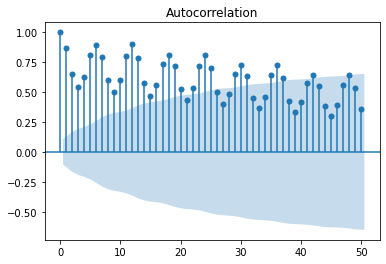

In [30]:
plot_acf(series,
         lags=50, # lag is the temporal shift
        )
print()

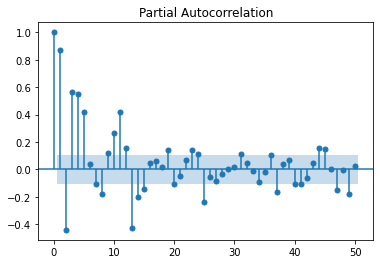

In [31]:
plot_pacf(series,
          lags=50
         )
print()

# Naive (Persistence) model

Before creating forecasting model based on machine learning algorithms let's create the most simple model for forecasting - Persistance model. Its main idea is to give a current value as a prediction for the next value.

We create this model as a baseline for our further modeling. Performance of the Persistance model helps us to understand whether our new model is better or not.

To make comprasions of models more reliable we will use the same structure in every model:
1. We split training dataset into training and test sets 50/50.
2. For validating we will use walk-forward validation.
3. It will be rolling forecast (always append new values to the model to improve performance)
4. As a performance metric we will use RMSE (root mean squared error)

RMSE: 8.6431397681207


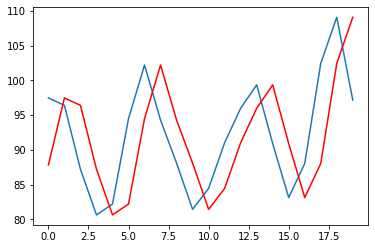

In [3]:
# create a X data vector
X = series.values
# make sure every value in vector is a number
X = X.astype('float32')
# create a split point
train_size = int(len(X) * 0.5)
# split X vector in two without shuffling (to reamin temporal structure)
train, test = X[:train_size], X[train_size:]
# make a list of all previous values 
# this list will be filled with new values as they appears
history = [x for x in train]
# create empty list for predictions
predictions = list()
for i in range(len(test)):
    # make a prediction (choose last point from history)
    yhat = history[-1]
    # add prediction to the list
    predictions.append(yhat)
    # look at observation
    obs = test[i]
    # append current observation to the history
    history.append(obs)
# calculate RMSE
rmse = sqrt(mean_squared_error(predictions, test))
print(f'RMSE: {rmse}')
# plot predictions and real values on graph
plt.plot(test[:20])
plt.plot(predictions[:20], color='red')

So RMSE=8.643 is our starting point. Following models must have perfomances better than this. Let's look how far we can get.

# Developing ARIMA

ARIMA algorithm based on three hyperparameters: p, q, d.
p - number of lags
q - number of integrations
d - window width for moving average
We can try to guess optimal numbers by using autocorrelation and partial autocorrelation plots but instead we just use grid search.

I will write two functions for this purpouse. First function will evaluate a single model with certain ARIMA hyperparameters and give us RMSE value. Second function will iterate all combinations of p, d, q and using first function evaluate each model and tell us which model has lowest RMSE.

The first function will have 4 different form:
1. Evaluate simple ARIMA model
2. Evaluate ARIMA model with prior boxcox transformation
3. Evaluate ARIMA model with seasonal decomposition
4. Evaluate ARIMA model with seasonal decomposition and prior boxcox transformation

In [5]:
# function that evaluates a single ARIMA model
# for a given order (p, d, q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # create empty list of predictions
    predictions = list()
    for t in range(len(test)):
        # initiate model
        model = ARIMA(history, order=arima_order)
        # fit model
        model_fit = model.fit(disp=0)
        # make a prediction
        yhat = model_fit.forecast()[0]
        # append prediction to the list
        predictions.append(yhat)
        # append current observation to history
        history.append(test[t])
    # calculate error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [6]:
# evaluate all combinations of p, d, q for ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    # initiate best score as infinite (we looking for the lowest)
    # initiate best configuration as None
    best_score, best_cfg = float("inf"), None
    # create nested loops for iterating all posible combinations of p, d and q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                # if given order cause error we just skip this model
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

The code below based on my experiments, that I am not including here.

In [7]:
# make grid for grid search
# for numbers of lags we give a big range of numbers
p_values = range(2, 8)
# numbers of integrations that bigger than 2 causes error
d_values = range(3)
# width of moving average window also will be not so great
q_values = range(3)
# evaluate models on original time series
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(2, 0, 0) RMSE=7.623
ARIMA(2, 0, 1) RMSE=6.964
ARIMA(2, 0, 2) RMSE=6.151
ARIMA(2, 1, 0) RMSE=5.789
ARIMA(2, 2, 0) RMSE=8.701
ARIMA(3, 0, 0) RMSE=5.787
ARIMA(3, 1, 0) RMSE=4.671
ARIMA(3, 1, 1) RMSE=4.131
ARIMA(3, 2, 0) RMSE=7.207
ARIMA(3, 2, 2) RMSE=4.153
ARIMA(4, 0, 0) RMSE=4.694
ARIMA(4, 0, 1) RMSE=4.148
ARIMA(4, 1, 0) RMSE=4.034
ARIMA(4, 1, 1) RMSE=4.016
ARIMA(4, 2, 0) RMSE=5.553
ARIMA(5, 0, 0) RMSE=4.062
ARIMA(5, 0, 1) RMSE=4.061
ARIMA(5, 1, 0) RMSE=4.026
ARIMA(5, 1, 1) RMSE=3.969
ARIMA(5, 2, 0) RMSE=4.858
ARIMA(5, 2, 1) RMSE=4.054
ARIMA(6, 0, 0) RMSE=4.063
ARIMA(6, 0, 1) RMSE=3.921
ARIMA(6, 1, 0) RMSE=4.038
ARIMA(6, 1, 1) RMSE=4.021
ARIMA(6, 2, 0) RMSE=4.350
ARIMA(7, 0, 0) RMSE=4.079
ARIMA(7, 0, 1) RMSE=4.067
ARIMA(7, 1, 0) RMSE=3.990
ARIMA(7, 1, 1) RMSE=4.022
ARIMA(7, 2, 0) RMSE=4.368
Best ARIMA(6, 0, 1) RMSE=3.921


Our new best score is 3.921 with p=6, d=0, q=1

Let's try same model with boxcox transformation
We will implement boxcox transformation on the history, fit model and make a prediction, after that we need to invert boxcox transformation. I will write a function for this

In [7]:
def inverse_boxcox(value, lam):
    if lam == 0:
        return exp(value)
    return exp(log(lam * value + 1) / lam)

In [9]:
def evaluate_arima_boxcox_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # create an empty list
    predictions = list()
    for t in range(len(test)):
        # transform our data
        # boxcox function also return lamba value we need it to invert transformation
        transformed, lam = boxcox(history)
        # values lower than -5 is an error we need to cancel our transformation
        if lam < -5:
            transformed, lam = history, 1
        # prediction
        model = ARIMA(transformed, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        # invert prediction
        yhat = inverse_boxcox(yhat, lam)
        predictions.append(yhat)
        history.append(test[t])
    # calculate error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [10]:
def evaluate_boxcox_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_boxcox_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [11]:
p_values = range(2,8)
d_values = range(3)
q_values = range(3)
# evaluate models on original time series
evaluate_boxcox_models(series.values, p_values, d_values, q_values)

ARIMA(2, 0, 0) RMSE=7.592
ARIMA(2, 0, 1) RMSE=6.894
ARIMA(2, 0, 2) RMSE=6.130
ARIMA(2, 1, 0) RMSE=5.702
ARIMA(2, 2, 0) RMSE=8.595
ARIMA(3, 0, 0) RMSE=5.695
ARIMA(3, 1, 0) RMSE=4.608
ARIMA(3, 1, 1) RMSE=4.116
ARIMA(3, 2, 0) RMSE=7.137
ARIMA(3, 2, 2) RMSE=4.142
ARIMA(4, 0, 0) RMSE=4.628
ARIMA(4, 0, 1) RMSE=52.936
ARIMA(4, 1, 0) RMSE=3.989
ARIMA(4, 1, 1) RMSE=3.997
ARIMA(4, 2, 0) RMSE=5.495
ARIMA(5, 0, 0) RMSE=4.015
ARIMA(5, 0, 1) RMSE=4.010
ARIMA(5, 1, 0) RMSE=3.986
ARIMA(5, 1, 1) RMSE=3.982
ARIMA(5, 2, 0) RMSE=4.795
ARIMA(5, 2, 1) RMSE=4.009
ARIMA(6, 0, 0) RMSE=4.020
ARIMA(6, 0, 1) RMSE=4.261
ARIMA(6, 1, 0) RMSE=3.996
ARIMA(6, 1, 1) RMSE=4.003
ARIMA(6, 2, 0) RMSE=4.345
ARIMA(7, 0, 0) RMSE=4.036
ARIMA(7, 0, 1) RMSE=4.188
ARIMA(7, 1, 0) RMSE=3.966
ARIMA(7, 1, 1) RMSE=3.988
ARIMA(7, 2, 0) RMSE=4.366
Best ARIMA(7, 1, 0) RMSE=3.966


In general performances of many models slightly improved. But best performance is worse than in models without boxcox transformation.

For decomposition models we need our difference and inverse_difference functions that I write earlier. Let's see how good these models are.

In [4]:
def evaluate_arima_decomposition_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    months_in_year = 12
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # remove seasonal component
        diff = difference(history, months_in_year)
        # prediction
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        # invert difference
        yhat = inverse_difference(history, yhat, months_in_year)
        # append prediction to the list
        predictions.append(yhat)
        # append current obsrvation to the history
        history.append(test[t])
    # calculate error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [5]:
def evaluate_decomposition_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_decomposition_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [8]:
# make grid for grid search
p_values = range(2,8)
d_values = range(3)
q_values = range(3)
# evaluate models on original time series
evaluate_decomposition_models(series.values, p_values, d_values, q_values)

ARIMA(2, 0, 0) RMSE=3.148
ARIMA(2, 0, 1) RMSE=3.122
ARIMA(2, 0, 2) RMSE=3.160
ARIMA(2, 1, 0) RMSE=3.303
ARIMA(2, 1, 1) RMSE=3.147
ARIMA(2, 1, 2) RMSE=3.119
ARIMA(2, 2, 0) RMSE=4.111
ARIMA(2, 2, 1) RMSE=3.323
ARIMA(3, 0, 0) RMSE=3.114
ARIMA(3, 0, 1) RMSE=3.113
ARIMA(3, 0, 2) RMSE=3.165
ARIMA(3, 1, 0) RMSE=3.318
ARIMA(3, 1, 1) RMSE=3.119
ARIMA(3, 1, 2) RMSE=3.120
ARIMA(3, 2, 0) RMSE=3.960
ARIMA(3, 2, 1) RMSE=3.338
ARIMA(3, 2, 2) RMSE=3.314
ARIMA(4, 0, 0) RMSE=3.102
ARIMA(4, 0, 1) RMSE=3.106
ARIMA(4, 0, 2) RMSE=3.162
ARIMA(4, 1, 0) RMSE=3.306
ARIMA(4, 1, 1) RMSE=3.103
ARIMA(4, 2, 0) RMSE=3.922
ARIMA(4, 2, 1) RMSE=3.326
ARIMA(5, 0, 0) RMSE=3.115
ARIMA(5, 0, 1) RMSE=3.100
ARIMA(5, 0, 2) RMSE=3.036
ARIMA(5, 1, 0) RMSE=3.257
ARIMA(5, 1, 1) RMSE=3.117
ARIMA(5, 1, 2) RMSE=3.095
ARIMA(5, 2, 0) RMSE=3.762
ARIMA(5, 2, 1) RMSE=3.278
ARIMA(6, 0, 0) RMSE=3.118
ARIMA(6, 0, 1) RMSE=3.114
ARIMA(6, 1, 0) RMSE=3.272
ARIMA(6, 1, 1) RMSE=3.165
ARIMA(6, 2, 0) RMSE=3.707
ARIMA(7, 0, 0) RMSE=3.128
ARIMA(7, 0, 

Decomposition show itself worthy. Our new best score is 3.036. Let's try to combine boxcox transformation and seasonal decomposition and see will be there any good.

In [9]:
def evaluate_arima_final_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    months_in_year = 12
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # boxcox transform
        transformed, lam = boxcox(history)
        if lam < -5:
            transformed, lam = diff, 1
        # remove seasonal component
        diff = difference(transformed, months_in_year)
        # prediction
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        # invert difference before invert boxcox
        yhat = inverse_difference(transformed, yhat, months_in_year)
        # inverse boxcox
        yhat = inverse_boxcox(yhat, lam)
        predictions.append(yhat)
        history.append(test[t])
    # calculate error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [10]:
def evaluate_final_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_final_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [12]:
# make grid for grid search
p_values = range(2,8)
d_values = range(3)
q_values = range(3)
# evaluate models on original time series
evaluate_final_models(series.values, p_values, d_values, q_values)

ARIMA(2, 0, 0) RMSE=3.151
ARIMA(2, 0, 1) RMSE=3.120
ARIMA(2, 0, 2) RMSE=3.165
ARIMA(2, 1, 0) RMSE=3.275
ARIMA(2, 1, 1) RMSE=3.135
ARIMA(2, 1, 2) RMSE=3.103
ARIMA(2, 2, 0) RMSE=4.058
ARIMA(2, 2, 1) RMSE=3.295
ARIMA(3, 0, 0) RMSE=3.112
ARIMA(3, 0, 1) RMSE=3.107
ARIMA(3, 0, 2) RMSE=3.160
ARIMA(3, 1, 0) RMSE=3.290
ARIMA(3, 1, 1) RMSE=3.105
ARIMA(3, 1, 2) RMSE=3.105
ARIMA(3, 2, 0) RMSE=3.913
ARIMA(3, 2, 1) RMSE=3.310
ARIMA(3, 2, 2) RMSE=3.282
ARIMA(4, 0, 0) RMSE=3.101
ARIMA(4, 0, 1) RMSE=3.097
ARIMA(4, 0, 2) RMSE=3.156
ARIMA(4, 1, 0) RMSE=3.282
ARIMA(4, 2, 0) RMSE=3.877
ARIMA(4, 2, 1) RMSE=3.300
ARIMA(5, 0, 0) RMSE=3.112
ARIMA(5, 0, 1) RMSE=3.093
ARIMA(5, 0, 2) RMSE=3.035
ARIMA(5, 1, 0) RMSE=3.235
ARIMA(5, 1, 2) RMSE=3.078
ARIMA(5, 2, 0) RMSE=3.721
ARIMA(5, 2, 1) RMSE=3.254
ARIMA(6, 0, 0) RMSE=3.114
ARIMA(6, 0, 1) RMSE=3.138
ARIMA(6, 1, 0) RMSE=3.251
ARIMA(6, 2, 0) RMSE=3.665
ARIMA(7, 0, 0) RMSE=3.125
ARIMA(7, 0, 1) RMSE=3.159
ARIMA(7, 1, 0) RMSE=3.250
ARIMA(7, 1, 1) RMSE=3.139
ARIMA(7, 2, 

Ok, we use ARIMA model with decomposition and boxcox transformation, p=5, d=0, q=2.

Now I want to do last thing before validating model. 

# Residuals Analysis

Now we create a standalone model ARIMA(5, 0, 2), compare its predictions with real values. Next step is to analize distribution of residuals. Idealy it must be Gaussian with zero mean. It would mean that model's errors are random and do not depend on some factor that our model didn't take into consideration.

In [8]:
# prepare training dataset
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
months_in_year = 12
# make predictions
predictions = list()
for t in range(len(test)):
    # boxcox transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = diff, 1
    # remove seasonal component
    diff = difference(transformed, months_in_year)
    # prediction
    model = ARIMA(diff, order=(5,0,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert difference before invert boxcox
    yhat = inverse_difference(transformed, yhat, months_in_year)
    # inverse boxcox
    yhat = inverse_boxcox(yhat, lam)
    predictions.append(yhat)
    history.append(test[t])

residuals = [predictions[i] - test[i] for i in range(len(test))]

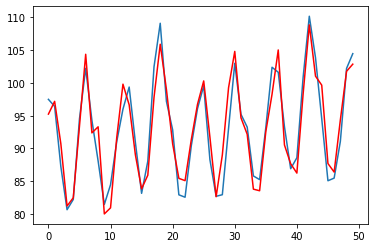

In [9]:
# let's compare predictions and real values
plt.plot(test[:50])
plt.plot(predictions[:50], color='red')

In [10]:
residuals_df = pd.DataFrame(residuals)

<AxesSubplot:ylabel='Density'>

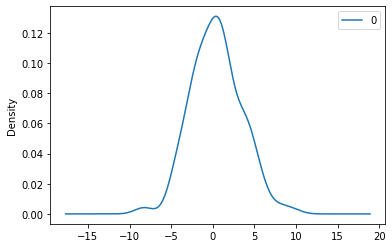

In [11]:
residuals_df.plot(kind='kde')

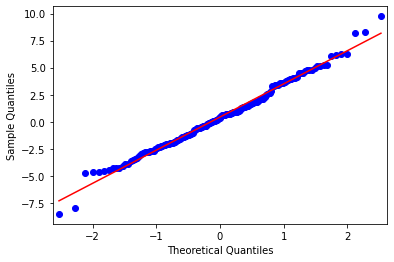

In [12]:
qqplot(residuals_df.iloc[:, 0], line='r')
print()

In [13]:
residuals_df.describe()

,0
count,174.000000
mean,0.433034
std,3.012396
min,-8.529961
25%,-1.719686
50%,0.420918
75%,2.130608
max,9.754568


From describe table we see that model have bias that equal 0.433

Tails of distribution differs from Gaussian a lot.

Now let's make a final step and validate our model. Besides we analize not only the RMSE value but the destribution of residuals.
We can take into considiration posibility to add this bias for our every prediction to improve performance.

# Validation of the model

In [14]:
# load training data
training_data = pd.read_csv('dataset.csv',
                            header=None,
                            index_col=0,
                            parse_dates=True,
                            squeeze=True
                           )
# load validation dataset
validation = pd.read_csv('validation.csv',
                         header=None,
                         index_col=0,
                         parse_dates=True,
                         squeeze=True
                        )
# prepare training dataset
# I decide to use bias in predictions
bias = -0.433
# create training data for ARIMA algorithm
X = training_data.values
X = X.astype('float32')
# create validation data for ARIMA algorithm
y = validation.values
y = y.astype('float32')
train, test = X, y
# create history
history = [x for x in train]
# create variable that contains interval for our difference and inverse_difference functions
months_in_year = 12
# make predictions
predictions = list()
for t in range(len(test)):
    # boxcox transform
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = diff, 1
    # remove seasonal component
    diff = difference(transformed, months_in_year)
    # prediction
    model = ARIMA(diff, order=(5,0,2))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert difference before invert boxcox
    yhat = inverse_difference(transformed, yhat, months_in_year)
    # inverse boxcox
    yhat = inverse_boxcox(yhat, lam)
    # add bias
    yhat = yhat + bias
    # append prediction to the list
    predictions.append(yhat)
    # append current value to the history
    history.append(test[t])

# make a list of residuals
residuals = [predictions[i] - test[i] for i in range(len(test))]
# calculate RMSE
rmse = sqrt(mean_squared_error(predictions, test))
print(f'RMSE equals {rmse}')

RMSE equals 3.9451187580533356


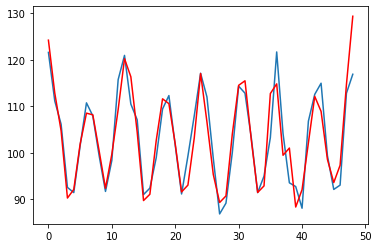

In [22]:
# compare predictions and real values
plt.plot(predictions)
plt.plot(test, color='red')

In [23]:
# create residuals data frame from residuals list
residuals_df = pd.DataFrame(residuals)

In [24]:
# look at statistic characteristics
residuals_df.describe()

,0
count,49.000000
mean,-0.053303
std,3.985638
min,-12.484140
25%,-1.877955
50%,-0.179210
75%,2.217954
max,6.871906


<AxesSubplot:ylabel='Density'>

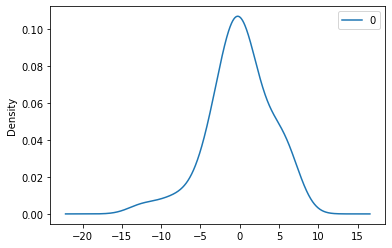

In [25]:
# look at density plot
residuals_df.plot(kind='kde')

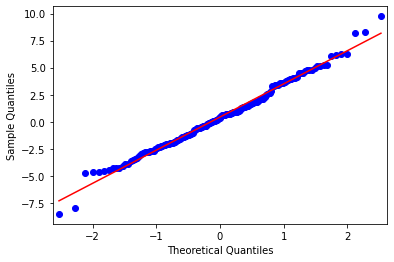

In [17]:
qqplot(residuals_df.iloc[:,0], line='r')
print()

In conclusion I may say that we create good forecasting model in terms of rolling forecast. Residuals of validation dataset almost have no bias and it may means that our model do as best as it can.

RMSE is bigger than in our test models, but if we return to our describe table for whole train dataset, we see mean value is about 86.8 and error 3.95 gives us 4% error (in average) which I consider acceptable.

Using power/log transform is dabatable, but seasonal decomposition is absolutly necessary.
Our model using coeficients p=5, d=0, q=2. That means we do not use Integration part of ARIMA model and we may use odinary ARMA model.

To increase performance we may try to use neural networks with LSTM layers maybe they can do forecasting better.

The main goal is achived, performance is acceptable.